# OSMnx overview: querying, simplifying, visualizing, saving

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://doi.org/10.1111/gean.70009)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)
  
Once you've perused the [features demo notebook](00-osmnx-features-demo.ipynb), this notebook demonstrates more details on querying for place boundaries and street networks, visualizing, and saving models to disk.

In [1]:
#!uv pip install --system --quiet osmnx[all]
from pathlib import Path

import geopandas as gpd
import osmnx as ox

ox.__version__

'2.0.6'

You can configure OSMnx using the `settings` module. See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.settings) for the settings you can configure. For example, by default OSMnx caches all server responses to prevent repeatedly hitting the server for the same query every time you run it. This both makes our code faster on subsequent runs and helps us be a "good neighbor" to the server. But you can turn caching off (or back on again) with the `use_cache` setting.

In [2]:
# turn response caching off
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console
ox.settings.use_cache = True
ox.settings.log_console = False

## Part 1: get place boundaries from OpenStreetMap

OSMnx lets you download place boundary geometries from OpenStreetMap, project them, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](03-graph-place-queries.ipynb).

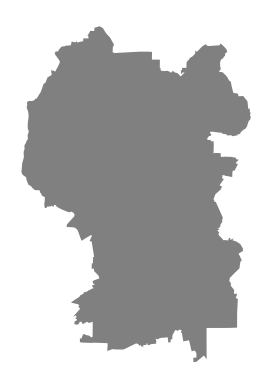

In [3]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocoder.geocode_to_gdf("Kuala Lumpur, Malaysia")
city_proj = ox.projection.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

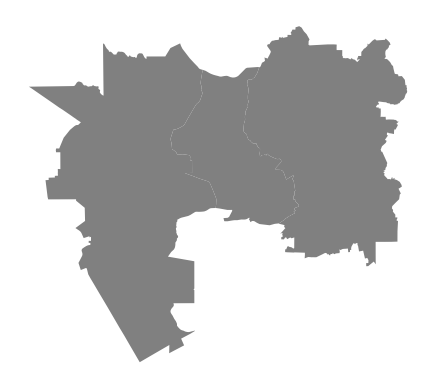

In [4]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Kuala Lumpur, Malaysia",
    "Petaling Jaya, Malaysia",
    "Shah Alam, Malaysia"
]
east_bay = ox.geocoder.geocode_to_gdf(place_names)
Path("data").mkdir(parents=True, exist_ok=True)
east_bay.to_file("./data/east_bay.gpkg", driver="GPKG")
east_bay = ox.projection.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [5]:
# if you know the OSM ID of the place(s) you want, you can query it directly
ox.geocoder.geocode_to_gdf(["R357794", "N8170768521", "W427818536"], by_osmid=True)

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((135.55901 35.13689, 135.55907 35.136...",135.559006,34.874916,135.878442,35.321221,408231285,relation,357794,35.011575,135.768144,boundary,administrative,14,0.699491,city,Kyoto,"Kyoto, Kyoto Prefecture, Japan"
1,POINT (13.38882 52.51699),13.383820,52.511988,13.393820,52.521988,133847340,node,8170768521,52.516988,13.388820,railway,station,30,0.000089,railway,Unter den Linden,"Unter den Linden, Friedrichstrasse, Dorotheens..."
2,"POLYGON ((-73.98141 40.76846, -73.98135 40.768...",-73.981408,40.764727,-73.949606,40.800314,332679977,way,427818536,40.782773,-73.965363,leisure,park,24,0.614770,park,Central Park,"Central Park, New York County, New York, Unite..."


## Part 2: download and model street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or GeoPackages for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-graph-place-queries.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - 'all' - download all OSM streets and paths, including private-access ones (this is the default network type unless you specify a different one)
  - 'all_public' - download all non-private OSM streets and paths
  - 'bike' - get all streets and paths that cyclists can use
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use

If you just want a fully bidirectional graph, just configure the `settings` module's `bidirectional_network_types` before creating your graph (it includes the "walk" network type by default).

#### Pass a lat-lng point and bounding box distance in meters
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

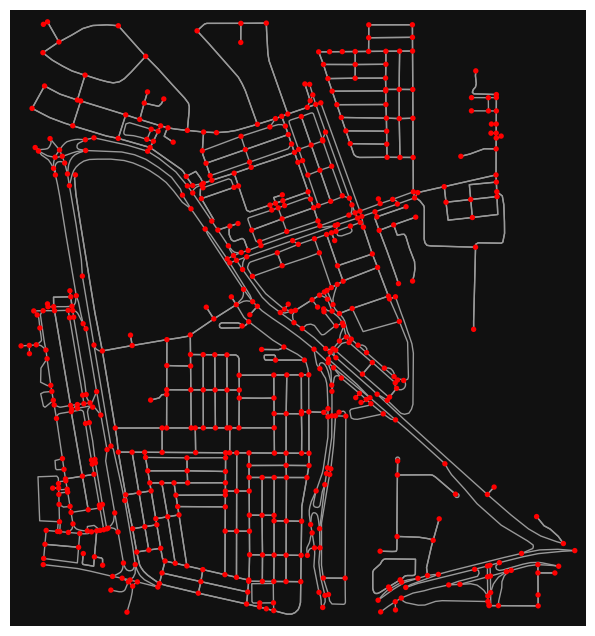

In [8]:
# define a point at the corner of California St and Mason St in SF
location_point = (3.1378849,101.629467)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="drive_service")

fig, ax = ox.plot.plot_graph(G, node_color="r")

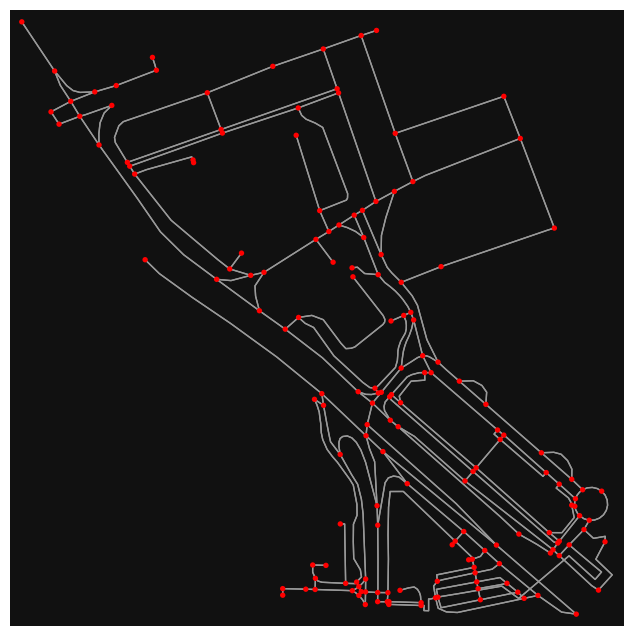

In [9]:
# create network only of nodes within 500m walking along the network from point
G = ox.graph.graph_from_point(location_point, dist=500, dist_type="network", network_type="walk")
fig, ax = ox.plot.plot_graph(G, node_color="r")

## Part 3: simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [this notebook](04-simplify-graph-consolidate-nodes.ipynb).

In [ ]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph.graph_from_point(
    location_point,
    network_type="drive_service",
    dist=500,
    simplify=False,
)

In [ ]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node, None, None) else "y" for node in G.nodes()]
fig, ax = ox.plot.plot_graph(G, node_color=nc)

The dots above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

In [ ]:
# simplify the network
G = ox.simplification.simplify_graph(G)
fig, ax = ox.plot.plot_graph(G, node_color="r")

In [ ]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot.plot_graph(
    G,
    node_color="w",
    node_edgecolor="k",
    node_size=50,
    edge_color=ec,
    edge_linewidth=3,
)

In [ ]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot.plot_graph(
    G,
    node_color="w",
    node_edgecolor="k",
    node_size=50,
    edge_color=ec,
    edge_linewidth=3,
)

In [ ]:
# highlight all one-way edges in the mission district network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G2.edges(keys=True, data=True)]
fig, ax = ox.plot.plot_graph(G2, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

## Part 4: saving networks to disk

For more examples of saving and loading networks to/from disk, see [this notebook](05-save-load-networks.ipynb).

In [ ]:
# save street network as GeoPackage to work with in GIS
ox.io.save_graph_geopackage(G, filepath="./data/network.gpkg")

In [ ]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.io.save_graphml(G, filepath="./data/network.graphml")

## Part 5: calculate basic network indicators

In [ ]:
# calculate basic street network metrics and display average circuity
stats = ox.stats.basic_stats(G)
stats["circuity_avg"]

In this street network, the streets are ~14% more circuitous than the straight-lines paths would be.

For examples of analyzing street networks, see [this example](06-stats-indicators-centrality.ipynb).